In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Análisis exploratorio de Ventas (ventas.txt)
En este archivo, podemos encontrar las ventas diarias del producto en cuestión, discriminadas por unidades.
El objetivo de notebook será generar un dataset preprocesado que acumule las ventas para los distintos puntos de venta.

Las columnas son: 
- fecha: Fecha de venta.
- id_pos: Identificador único de Punto de Venta.
- cantidad_envios: Cantidad de productos vendidos.
- canal: Es la clase de tienda en la que se realizó la venta.

Realizamos la importación del archivo de ventas, y una descripción del dataset: 
- utilizamos la función **describe** que nos ofrece estadísticas sobre el dataset
- utilizamos la función **info** que visualiza el tipo de datos de las columnas
- utilizamos la función **sample** que nos retorna un ejemplo de datos

In [1]:
df_ventas = (
    pd.read_csv(
        './data/ventas.txt', 
        delimiter = "|", 
        infer_datetime_format=True, 
        parse_dates=[0]
    )
)

df_ventas.sample(5)

fecha  id_pos  unidades    canal
257246 2014-11-21    7689         1  ALMACEN
117523 2013-11-28    7534         1  ALMACEN
87743  2012-12-21    3998         7  ALMACEN
132973 2013-12-05    5634         1  ALMACEN
194611 2013-12-18   11504         1  ALMACEN

Realizamos un análisis descriptivo de las ventas

In [2]:
df_ventas.describe(include='all')

fecha         id_pos       unidades    canal
count                266436  266436.000000  266436.000000   266436
unique                  276            NaN            NaN        4
top     2013-12-24 00:00:00            NaN            NaN  ALMACEN
freq                   9726            NaN            NaN   265207
first   2012-10-01 00:00:00            NaN            NaN      NaN
last    2014-11-30 00:00:00            NaN            NaN      NaN
mean                    NaN    7973.083667       2.378481      NaN
std                     NaN    4707.704857       2.391836      NaN
min                     NaN    3142.000000     -29.000000      NaN
25%                     NaN    4964.000000       1.000000      NaN
50%                     NaN    6701.000000       2.000000      NaN
75%                     NaN    9500.000000       3.000000      NaN
max                     NaN   63432.000000      59.000000      NaN

In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266436 entries, 0 to 266435
Data columns (total 4 columns):
fecha       266436 non-null datetime64[ns]
id_pos      266436 non-null int64
unidades    266436 non-null int64
canal       266436 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.1+ MB


In [5]:
# ¿existen valores nan en el dataset?
df_ventas.isna().any()

fecha       False
id_pos      False
unidades    False
canal       False
dtype: bool

Con esta descripción obtenemos las siguientes conclusiones:
 - la fecha inicial es 01/10/2012 y el fin es 30/11/2014
 - tenemos 266436 muestras
 - tenemos 4 tipos de **canales**
 - en unidades hay valores negativos (posibles errores)
 - no existen valores faltantes en las columnas que debamos imputar
____
### Preprocesamiento columnas
En los siguientes apartados se revisarán los valores de las columnas del dataset para comprobar valores faltantes, errores, balanceo de datos, etc.

#### Análisis **canales**
Como podemos observar en la tabla anterior tenemos 4 tipos de canales, los cuales son: MAXIKIOSKO, ALMACEN, SUPERMERCADOS Y PARTICULARES

In [6]:
list(df_ventas.canal.unique())

['MAXIKIOSCO', 'ALMACEN', 'SUPERMERCADOS', 'PARTICULARES']

Podríamos ver la frecuencia de cada uno, y cuantos valores hay faltantes:

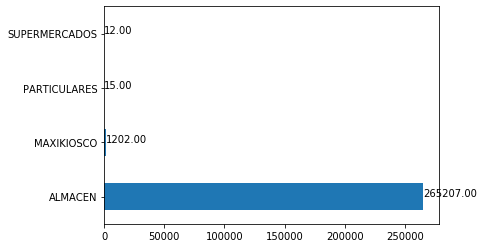

In [7]:
# imprimimos un gráfico de barras
ax = df_ventas.canal.fillna("FALTANTE").value_counts().plot.barh()
#imprimimos los labels númericos
[ax.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(df_ventas.canal.value_counts())];

Como se puede observar, la mayoría de nuestras muestras son del tipo "ALMACEN" (tenemos una alta cardinalidad en el atributo canal para la categoría almacen), y no posee valores faltantes. Intentamos completar los valores faltantes con el operador "fillna" pero no completó ningún elemento.  Podríamos agrupar todas las demás categorías en una sola con el valor "OTROS", aunque no sería de mucho interés lo hacemos solo para obtener algo un poco más ordenado.

[Text(265207, 0, '265207.00'), Text(1229, 1, '1229.00')]

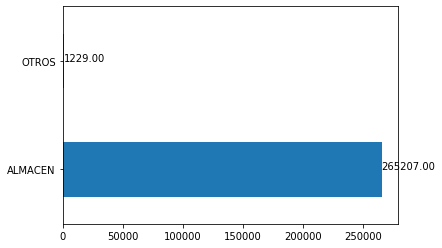

In [8]:
def group_canal(df_ventas):
    df_ventas.canal.loc[df_ventas.canal != "ALMACEN"] = "OTROS"
    
group_canal(df_ventas)
ax = df_ventas.canal.fillna("FALTANTE").value_counts().plot.barh()
[ax.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(df_ventas.canal.value_counts())]

La cantidad de ejemplos de "OTROS" representa el 0.5%, por ende la mayoría de las muestras caeran en "ALMACEN". 

Decidimos remover la columna canal por el momento, ya que no nos divide los datos de tal manera que nos genere significado.

In [9]:
df_ventas = df_ventas.drop("canal", axis=1)

____
#### Análisis de **unidades**

Verificamos los valores de **unidades** para descubrir faltantes o errores, realizamos con un diagrama de cajas para verificar si existen valores fuera de rango. 

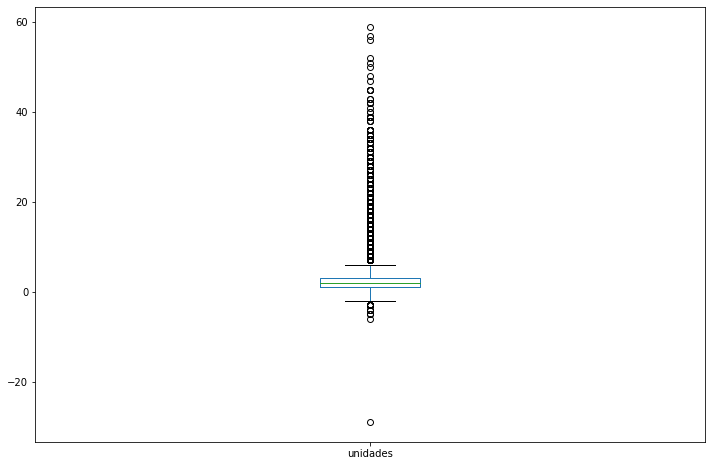

In [10]:
df_ventas.unidades.plot.box(figsize=(12,8))

En el gráfico anterior, podemos ver varios valores atípicos (outliers). No deberíamos quitar los valores atípicos positivos ya que puede ser que dependiendo donde se encuentre el punto de venta, podrían ocurrir dichas ventas con valores de unidades altos, por ejemplo en una zona céntrica. Incluso, dada la consigna del ejercicio, pueden faltar muchos datos para realizar las pruebas.

Tendríamos que verificar que son los valores negativos de unidades. Observamos 114 muestras que poseen valores negativos, se visualizan los primeros 10 ordenados por unidades

In [11]:
# vamos a guardar las ventas que tienen valores de unidades negativas
df_ventas_negativas = (
    df_ventas[lambda df: df.unidades <= 0]
    .sort_values(['unidades',"id_pos"], ascending=True)
)

In [12]:
print("(filas, columnas): ",df_ventas_negativas.shape)
df_ventas_negativas.head(10)

(filas, columnas):  (114, 3)


fecha  id_pos  unidades
161838 2013-12-13    3881       -29
247549 2013-12-27   16628        -6
111947 2013-11-21    3797        -5
68310  2012-12-17   34079        -5
67514  2012-12-17    5479        -4
113520 2013-11-23    6626        -4
247166 2013-12-26   11716        -4
83884  2012-12-21   12961        -4
219925 2013-12-22    3797        -3
248865 2013-12-28    5533        -3

¿Estas unidades corresponderán a devoluciones?, ¿serán errores de tipeo?
Según cuál caso ocurriese, se podría recurrir a alguna de estas soluciones: 

- si fueran devoluciones 
    tendría que existir una compra en días anteriores de la misma cantidad
- si fueran errores de tipeo, 
    tendríamos que cambiar el signo de dichas muestras
- si fueran otro tipo de error,
    deberíamos descartar esa muestra 
   
Como en realidad lo que queremos predecir son las ventas, no nos interesa si existen devoluciones; en el supuesto caso que fueran errores de tipeo no tendríamos forma de comprobarlo. 
La opción de descartar dichos elementos de la muestra no es tan descabellada: tenemos 266436 de las cuales 114 son las que tienen valores negativos en unidades. Estas 114 muestras representan el 0.05% de las muestras.

Se agrega una notebook donde se intenta verificar cuál es la cantidad de de estos 114 elementos que podrían ser devoluciones correctas. [Analisis alternativo](./00-alternativo.ipynb)

Procedemos a eliminar las ventas donde unidades posee valores negativos:

In [13]:
df_ventas = df_ventas.drop(df_ventas.loc[lambda df: df.unidades <=0].index)
print(df_ventas.shape)

(266322, 3)


Volvemos a graficar el diagrama de caja para comprobar que dichos valores fueron removidos:

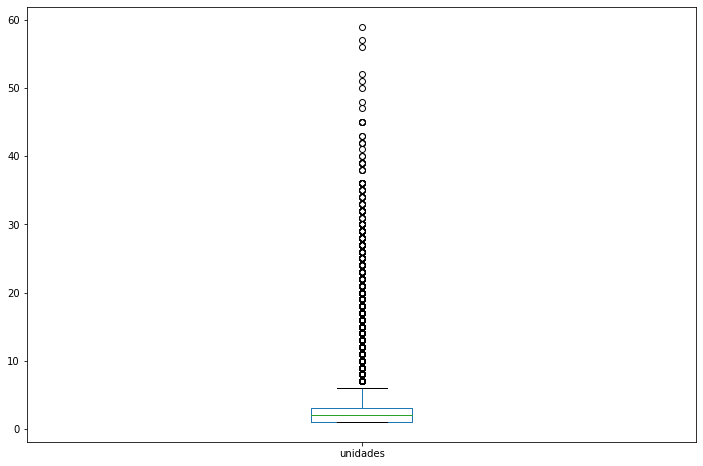

In [14]:
df_ventas.unidades.plot.box(figsize=(12,8))

Observamos que nuestras muestras se agrupan en su mayoría con valores pequeños, entre 1 y 10, por fechas de ventas. Es decir en la mayoría de los POS, por día, venden pocas unidades.

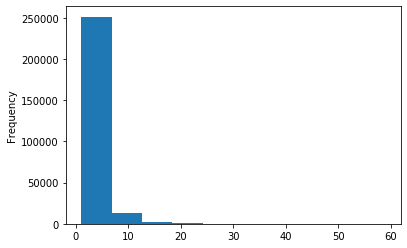

In [15]:
df_ventas.set_index('fecha').unidades.plot.hist()

____

#### Análisis **identificador punto de venta (id_pos)**
Esta columna debe tener valores númericos, los cuales representan los identificadores de los puntos de venta o **pos**. Esta columna no debe poseer valores nulos, faltantes o con errores (negativos).

Comprobamos que el tipo de datos es númerico:

In [15]:
str(df_ventas.id_pos.dtype)

'int64'

Con el siguiente código verificamos que los valores de id_pos no tienen valores faltantes o con errores

In [16]:
(
    #no hay faltantes
    df_ventas.id_pos.isna().any() 
    #no hay negativos (errores)
    or (df_ventas.id_pos <= 0).any()
)

False

Según nuestro Dataset tenemos 12302 puntos de ventas que han realizado al menos 1 venta. En el otro archivo, hemos descubierto que hay más POS, pero algunos no poseen ventas (candidatos a predecir 0 en ventas)

In [17]:
df_ventas.id_pos.unique().size

12302

### Analizando nuestros datos
Podemos totabilizar las ventas por id_pos:

In [18]:
# agrupamos por id_pos y calculamos métricas
grouped_by_ventas = (
    df_ventas.groupby("id_pos")
    .agg({"id_pos":["count"], "unidades":["sum", "mean", "std"]})
)

# cambiamos el nombre de las columnas
grouped_by_ventas.columns = [
    "cantidad_ventas", 
    "unidades_suma",
    "unidades_media", 
    "unidades_desviacion"
]

# ordenamos los valores por cantidad de ventas acumuladas y retornamos 15
grouped_by_ventas.sort_values("cantidad_ventas", ascending=False).head(5)

cantidad_ventas  unidades_suma  unidades_media  unidades_desviacion
id_pos                                                                     
4369                 98            296        3.020408             2.580576
3683                 95            304        3.200000             3.086001
4695                 93            317        3.408602             3.710258
4761                 91            472        5.186813             5.324810
3735                 91            343        3.769231             4.986820

In [19]:
# Obtenemos las últimas 5
grouped_by_ventas.sort_values("cantidad_ventas", ascending=False).tail(5)

cantidad_ventas  unidades_suma  unidades_media  unidades_desviacion
id_pos                                                                     
17213                 1              1             1.0                  NaN
17208                 1              2             2.0                  NaN
17203                 1              2             2.0                  NaN
17198                 1              2             2.0                  NaN
12083                 1              1             1.0                  NaN

*Nota: la desviación da NaN, porque es la única muestra.*

Con un histograma podemos conocer la frecuencia de los valores de cantidad_ventas. Con ellos podemos observar que los valores entre 49.5 en adelante se encuentran en menor proporción. Los datos nos están diciendo que los puntos de ventas tienen poca cantidad de ventas individualmente en su mayoría.

Los datos nos dicen que entre 0 y 20 ventas tenemos 7557 y mayores a 20 tenemos 4745 puntos de ventas.
Podríamos etiquetar estos negocios con "MUCHAS" o "POCAS" ventas en el dataset de pos.txt.

(0.903, 10.7]    4601
(10.7, 20.4]     2956
(20.4, 30.1]     1243
(39.8, 49.5]     1131
(30.1, 39.8]     1086
(49.5, 59.2]      776
(59.2, 68.9]      309
(68.9, 78.6]      155
(78.6, 88.3]       35
(88.3, 98.0]       10
Name: cantidad_ventas, dtype: int64


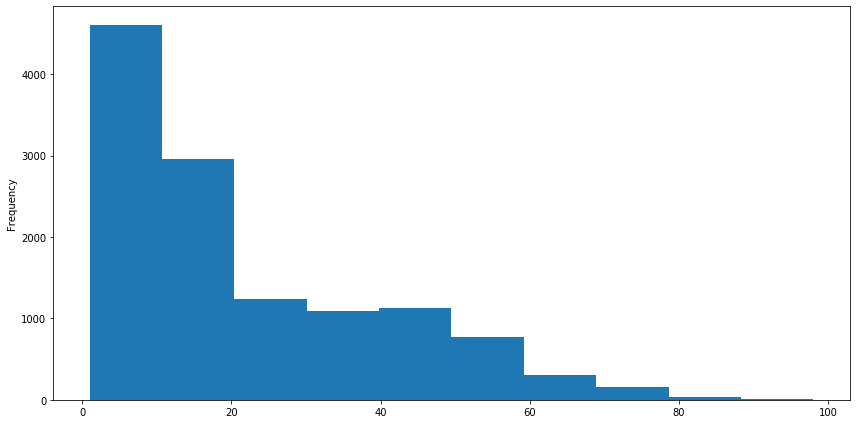

In [20]:
grouped_by_ventas.cantidad_ventas.plot.hist(bins=10, figsize=(12,6))
print(pd.cut(grouped_by_ventas.cantidad_ventas, bins=10).value_counts())
plt.tight_layout()

### Agregando características
Podríamos generar nuevas características derivadas del atributo fecha, las cuales pueden ser: 
- dayofyear: corresponde al día del año (1-365)
- weekofyear: corresponde a la semana del año (1-52)
- dayofweek: corresponde al día de la semana ( 0 [lunes] - 6 [domingo] )
- ...

In [21]:
from src.add_date_features import add_date_features
add_date_features(df_ventas, "fecha").head()

id_pos  unidades  dayofweek  year  month  dayofyear  dayofmonth  \
0    8495         4          0  2012     10        275           1   
1    8571         1          2  2012     10        284          10   
2    8915         1          3  2012     10        285          11   
3    8915         3          4  2012     10        286          12   
4    8923         1          5  2012     10        287          13   

   weekofyear  is_weekend  
0          40           0  
1          41           0  
2          41           0  
3          41           0  
4          41           1

In [22]:
df_ventas = df_ventas.drop('date', axis=1, errors='ignore')

In [23]:
df_ventas.sample(6)

fecha  id_pos  unidades  dayofweek  year  month  dayofyear  \
38868  2012-12-08    5812         5          5  2012     12        343   
88130  2012-12-21    6919         4          4  2012     12        356   
97690  2012-12-23    6461         2          6  2012     12        358   
103406 2012-12-29   15611         1          5  2012     12        364   
259617 2014-11-24    7229         2          0  2014     11        328   
202478 2013-12-19    6805         1          3  2013     12        353   

        dayofmonth  weekofyear  is_weekend  
38868            8          49           1  
88130           21          51           0  
97690           23          51           1  
103406          29          52           1  
259617          24          48           0  
202478          19          51           0

### Visualizando nuestros datos
Graficamos un diagrama de lineas y otro scatter con las ventas por fecha, agrupado por mes. Se puede observar un pico en las ventas en el mes de diciembre, naturalmente el producto tenía su pico en esos meses según la descripción del problema.

Verificamos cuantas muestras totales tenemos por mes: 

In [24]:
df_ventas.set_index("fecha").resample("M").size()

fecha
2012-10-31        55
2012-11-30     21050
2012-12-31     82337
2013-01-31         0
2013-02-28         0
2013-03-31         0
2013-04-30         0
2013-05-31         0
2013-06-30        13
2013-07-31        18
2013-08-31        17
2013-09-30         4
2013-10-31       289
2013-11-30     16890
2013-12-31    128360
2014-01-31         0
2014-02-28         0
2014-03-31         0
2014-04-30         0
2014-05-31         0
2014-06-30         0
2014-07-31         0
2014-08-31         0
2014-09-30        31
2014-10-31       393
2014-11-30     16865
Freq: M, dtype: int64

Con la técnica de "resampling", agrupamos los datos por mes, sumarizamos las unidades y realizamos un gráfico.

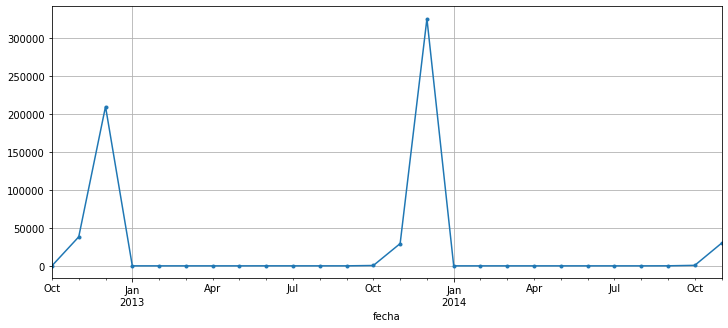

In [25]:
# realizamos un gráfico agrupando por mes
ax = ( 
    df_ventas.set_index("fecha")
    .resample("M")
    .unidades.sum()
    .plot.line(figsize=(12,5), marker='.')
)
plt.grid(True)

Realizamos el mismo gráfico, pero con los datos de las ventas diarias. Esto nos provee una vista de como nuestros datos se esparcen con respecto a las fechas. 

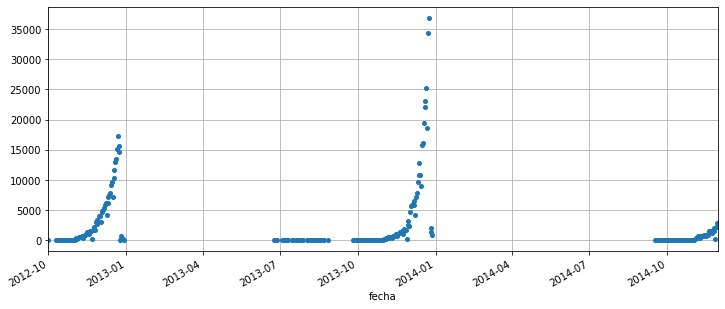

In [26]:
# Realizamos el mismo gráfico, pero con los puntos por día
ax = ( 
    df_ventas.set_index("fecha")
    .groupby('fecha').unidades.sum()
    .plot.line(figsize=(12,5), marker='.', grid=True, style="o", ms="8")
)

Visualizamos la cantidad de unidades por **día del año** que contiene nuestro dataset. 
Las fechas están codificadas como el día del año. Esto nos permite en el mismo gráfico, marcar las 3 lineas de ventas. El día del año corresponde a un número entre 1 y 365 ( o 366 si es un año bisiesto )

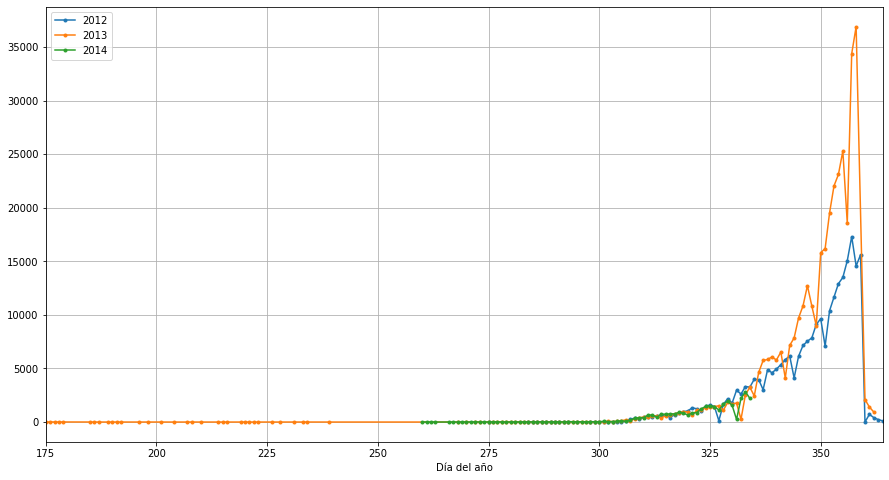

In [27]:
_, ax = plt.subplots(1,1, sharex=True, sharey=True)
for i in ["2012", "2013", "2014"]:
    data = df_ventas.set_index("fecha").loc[i]
    data.index = data.index.dayofyear
    data = data.groupby('fecha').unidades.sum()
    data.plot.line(figsize=(15,8), marker='.', ax=ax)
    ax.grid(True)
    ax.set_xlabel("Día del año")
ax.legend(["2012", "2013", "2014"])

## Conclusión del apartado

- Generamos atributos derivados de fechas
- Removimos las ventas que tenían unidades negativas
- Detectamos muchos valores outliers superiores, pero que los no quitamos dada la naturaleza del problema.

Procedemos a guardar nuestro dataset modificado. Los archivos parquet es un formato de datos columnar, que se utiliza en el almacenamiento de grandes volúmenes. Podríamos guardar un csv, pero el archivo parquet ocupa menos espacio en disco.

In [28]:
df_ventas.to_parquet('data/00-ventas.parquet')

Siguiente: [02-analisis-exploratorio-pos](./02-analisis-exploratorio-pos.ipynb)

Siguientex2: [Tratamiento-Predicción-Time-Series](./Tratamiento_TS.ipynb)

_______

## Análisis Descriptivo
Como una manera de realizar una predicción de producción, se realiza la predicción de ventas en general para el mes de diciembre. Esta resolución podría ser tomada como una solución gerencial; en cambio, en una solución por POS, podría ser tomada como una predicción de distribución donde los interesados sean los POS. 

Predicción de ventas generales: [predicción ventas generales](./00-01-prediccion-ventas-general.ipynb)

## Análisis descriptivo: respondiendo preguntas!
Podríamos obtener otras métricas que le sean interesantes al negocio,  como por ejemplo: 
    - que establecimiento vendió más productos en cantidad de unidades
    - que día es el que vendió más productos (general)
    - ...

### ¿Cuál establecimiento vendió más productos en cantidad de unidades?
El establecimiento que más productos vendió fue el id_pos: 4761 con 472 unidades

In [29]:
grouped_by_ventas.loc[grouped_by_ventas.unidades_suma.idxmax()]

cantidad_ventas         91.000000
unidades_suma          472.000000
unidades_media           5.186813
unidades_desviacion      5.324810
Name: 4761, dtype: float64

### ¿Cuál establecimiento tiene la media mas alta de productos?
El establecimiento 6656 es el que tiene la más alta media de unidades vendidas con 12.2 unidades.

In [30]:
grouped_by_ventas.loc[grouped_by_ventas.unidades_media.idxmax()]

cantidad_ventas         10.000000
unidades_suma          122.000000
unidades_media          12.200000
unidades_desviacion      6.338594
Name: 6656, dtype: float64

### ¿Cuál día es el que más productos se vendió? (general)
Como podemos observar el pico de ventas del año 2013 se encuentra el día 24 de diciembre, con 36882 unidades de ventas. En el año 2012, el pico de ventas se encuentra el día 22 de diciembre con 17303 ventas. Esto se puede llegar a explicar por el día en el que cae 24 en el año 2012, 22 de diciembre es sábado y 24, lunes. 

Esta conclusión se obtiene de que, normalmente, la gente no suele hacer compras los domingos dado que los lugares de ventas se encuentran cerrados. No obstante, está conclusión puede quedar anulada si los negocios tienen horario "de fiestas". 


In [31]:
( 
    df_ventas.set_index("fecha")
    .groupby('fecha')
    .agg({"unidades":[sum]})
    .sort_values(("unidades","sum"),ascending=False)
    .head(10)
)

unidades
                sum
fecha              
2013-12-24    36891
2013-12-23    34366
2013-12-21    25288
2013-12-20    23100
2013-12-19    22034
2013-12-18    19511
2013-12-22    18572
2012-12-22    17305
2013-12-17    16188
2013-12-16    15803

### ¿Cuál es el día y establecimiento en el que se vendieron más productos?
Podemos observar que en el top 10, menos 1 producto, todos son de diciembre. La mayoría de los productos son de la semana de fiestas (última semana de diciembre) y hay un solo caso de principio de mes con 48 ventas. 
Esos casos quizás correspondan a un día en el cual se realizó alguna promoción o descuento, pero no nos encontramos con estos datos para verificar.

In [32]:
(
    df_ventas.set_index('fecha')
    .groupby(['id_pos','fecha'])
    .agg({"unidades":["sum"]}).sort_values(("unidades", "sum"), ascending=False)
    .head(10)
)

unidades
                       sum
id_pos fecha              
6234   2013-12-23       59
7609   2013-12-19       58
5739   2012-11-26       56
3359   2013-12-21       52
8464   2013-12-23       52
15204  2013-12-23       51
4273   2013-12-24       50
7141   2013-12-03       48
6930   2013-12-21       46
12754  2012-12-16       45